Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CNN_XAI")

import requests, pickle
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/gdrive


SHAP funcion

In [ ]:
#######################################################
# SHAP
import scipy.special
import numpy as np
import itertools
import random


def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def func_model(model, x, y_predicted):
    X=np.expand_dims(x,2)
    y = model(X)
    return y[y_predicted]


def cal_shap(model, x,shapley_point, M, sp_size, MC, y_predicted):  
    #model for pretrained CNN model, x for input image
    #M for vector size (number of shapley values)
    #MC for monte carlo times, sp_size for super pixel size
    #shapley_point for which point we are calculating shapley value
    weights=np.zeros(M[0]*M[1],np.int)
    binom_M=np.zeros(M[0]*M[1],np.int)
    shapley_out = 0;
    for i in range(M[0]*M[1]):
        #X = np.zeros((MC,M+1))
        #X[:,-1] = 1
        #V = np.zeros((MC,M-1))
        if(M[0]*M[1]<=20):
            binom_M[i]=(scipy.special.binom(M[0]*M[1]-1,i))
            if(binom_M[i] > MC):
                weights[i] = MC 
            else:
                weights[i] = binom_M[i]
        else:
            weights[i] = MC
        shape_v = list(x.shape)
        #print(shape_v)
        shape_v.insert(0,weights[i])
        #print(shape_v)
        V_plus  = np.zeros(tuple(shape_v))
        V_minus = np.zeros(tuple(shape_v))
        #print("V_minus shape", V_minus.shape)
        if(binom_M[i]<=MC):  #all
            j=0
            #print("i=",i,list(itertools.combinations(range(M-1),i)))
            for s in list(itertools.combinations(range(M[0]*M[1]-1),i)):   #eliminate i
                s1=list(s)
                s2=list()
                for i0 in range(len(s1)):
                    if(s1[i0] >= shapley_point[1]*M[1]+shapley_point[0]):
                        s1[i0] = s1[i0] + 1
                    #sl_row=s1[i0]//M[1]
                    #print("s1[i0]",s1[i0])
                    #print("M[1]",M[1])
                    s1_col=s1[i0]%M[1]
                    s1_row=s1[i0]//M[1]
                    #print("s1_row",s1_row)
                    #print("s1_col",s1_col)
                    for u1 in range(sp_size[0]):
                        for u2 in range(sp_size[1]):
                            s2.append([u1+sp_size[0]*s1_row,u2+sp_size[1]*s1_col])
                s2=np.array(s2,np.int32)
                #print("s1",s1)
                #print("s2",s2)
                if(s2!=[]):
                    #print("s2",s2)
                    idx1=s2[:,0]
                    idx2=s2[:,1]
                    #print("x shape",x.shape)
                    #print("V shape",V_minus.shape)

                    #print("shape1",x[idx1,idx2,:].shape)
                    #print("shape2",V_minus[j,idx1,idx2,:].shape)

                    #if(np.ndim(V_plus)==4):
                    #    V_minus[j,idx1,idx2,0] = x[idx1,idx2,0]
                    #else:
                    V_minus[j,idx1,idx2] = x[idx1,idx2]
                #print("V_minus",V_minus)
                #print("old s2",s2)
                for u1 in range(sp_size[0]):
                    for u2 in range(sp_size[1]):
                        if(s2.ndim==1):
                            s2=np.append(s2,[u1+shapley_point[0]*sp_size[0],u2+shapley_point[1]*sp_size[1]],axis=0)
                            s2=np.expand_dims(s2,axis=0)
                        else:
                            s2=np.append(s2,[[u1+shapley_point[0]*sp_size[0],u2+shapley_point[1]*sp_size[1]]],axis=0)
                        #if(s2.ndim==1):
                        #    s2=np.expand_dims(s2,axis=0)
                #print("new s2",s2)

                #print("s2",s2)
                idx1=s2[:,0]
                idx2=s2[:,1]
                V_plus[j,idx1,idx2] = x[idx1,idx2]
                #print("V_plus",V_plus)
                j = j+1

        else:
            for j in range(MC):
                s1 = list(random_combination(range(M[0]*M[1]-1),i))   #
                s2 = list()
                for i0 in range(len(s1)):
                    if(s1[i0] >= shapley_point[1]*M[1]+shapley_point[0]):
                        s1[i0] = s1[i0] + 1
                    s1_row=s1[i0]//M[1]
                    s1_col=s1[i0]%M[1]
                    for u1 in range(sp_size[0]):
                        for u2 in range(sp_size[1]):
                            s2.append([u1+sp_size[0]*s1_row,u2+sp_size[1]*s1_col])
                s2=np.array(s2)
                if(s2!=[]):
                    idx1=s2[:,0]
                    idx2=s2[:,1]
                    #print("s2:",s2)
                    V_minus[j,idx1,idx2] = x[idx1,idx2]
                #print("V_minus",V_minus)
                #print(sp_size)
                for u1 in range(sp_size[0]):
                    for u2 in range(sp_size[1]):
                        #print("old s2",s2)
                        if(s2.ndim==1):
                            s2=np.append(s2,[u1+shapley_point[0]*sp_size[0],u2+shapley_point[1]*sp_size[1]],axis=0)
                            s2=np.expand_dims(s2,axis=0)
                        else:
                            s2=np.append(s2,[[u1+shapley_point[0]*sp_size[0],u2+shapley_point[1]*sp_size[1]]],axis=0)
                        #print("new s2",s2)
                idx1=s2[:,0]
                idx2=s2[:,1]
                V_plus[j,idx1,idx2] = x[idx1,idx2]
                #print("V_plus",V_plus)


        #print("V_minus",V_minus)
        #print("V_plus",V_plus)
        #print(V_plus.shape)
        #y_plus  = func_model(model, V_plus,  y_predicted)
        #y_minus = func_model(model, V_minus, y_predicted)
        if(V_plus.ndim==3):
            V_plus = np.expand_dims(V_plus,3)
        y_tmp1 = model(V_plus)
        y_plus = y_tmp1[:,y_predicted]

        if(V_minus.ndim==3):
            V_minus = np.expand_dims(V_minus,3)
        y_tmp2 = model(V_minus)
        #print("y_tmp2",y_tmp2)
        y_minus= y_tmp2[:,y_predicted]

        shapley_out += sum(y_plus-y_minus)/weights[i]/(M[0]*M[1]-1);
        #print("y_plus:",y_plus)
        #print("y_minus:",y_minus)
        #print("shap_out",shapley_out)
        #print("V_minus",V_minus[0,:,0,0].T)
        #print(V_minus)
        #print("V_plus")
        #print("V_plus",V_plus[0,:,0,0].T)     
    #print(weights)
    return shapley_out
def shap_user_defined(x,model,sp_size=[2,1],MC=1000):
    size_x = list(x[0].shape)
    #print("x.shape",x.shape)   #(n,40,1)
    M = [int(a/b) for a, b in zip(size_x, sp_size)]
    shapley=np.zeros(size_x)
    #print(shapley)
    #print("M",M)  

    for m in range(x.shape[0]): # for 1 image 
        for i1 in range(M[0]):
            for i2 in range(M[1]):
                y_pre=model.predict(x[m:m+1])
                predicted_y=np.argmax(y_pre)
                #print(M)
                tmp1=cal_shap(model,x[m],[i1,i2],M,sp_size,MC,predicted_y)
                # xm:(40,1) [i1,i2] = [0,0] to [19,19]  
                #tmp1=cal_shap(model,x[m],i,M,sp_size,MC,predicted_y)
                for j1 in range(sp_size[0]):
                    for j2 in range(sp_size[1]):
                        shapley[i1*sp_size[0]+j1,i2*sp_size[1]+j2] = tmp1
    return shapley
    ####################################################################################

drop rate

In [ ]:
# drop rate
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)
#######################################################################

train dataset

In [ ]:


with open('./MNIST1D.pkl', 'rb') as handle:
    dataset = pickle.load(handle)
weight_decay = 5e-4 
#print(dataset.keys())

x_train = dataset['x']    
y_train = dataset['y']
x_test = dataset['x_test']
y_test = dataset['y_test'] 


model = Sequential()
#print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
x_train = np.expand_dims(x_train,2)
x_test = np.expand_dims(x_test,2)

one_hot_y = np.zeros((y_train.size,10))
one_hot_y[np.arange(y_train.size),y_train]=1
y_train = one_hot_y

one_hot_y_test = np.zeros((y_test.size,10))
one_hot_y_test[np.arange(y_test.size),y_test]=1
y_test = one_hot_y


model.add(layers.Conv1D(25,5,1,'same',activation='relu',kernel_regularizer=regularizers.l2(weight_decay),bias_regularizer=regularizers.l2(weight_decay)))
model.add(layers.Conv1D(25,3,1,'same',activation='relu',kernel_regularizer=regularizers.l2(weight_decay),bias_regularizer=regularizers.l2(weight_decay)))
model.add(layers.Conv1D(25,3,1,'same',activation='relu',kernel_regularizer=regularizers.l2(weight_decay),bias_regularizer=regularizers.l2(weight_decay)))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='softmax',kernel_regularizer=regularizers.l2(weight_decay),bias_regularizer=regularizers.l2(weight_decay)))


loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(optimizer='sgd',loss=loss_fn,metrics=['accuracy'])

logdir = "training_result"
tensorboard_callback = keras.callbacks.TensorBoard(logdir,histogram_freq=1)
history = model.fit(x_train,y_train,epochs=200, callbacks=tensorboard_callback)
#history = model.fit(x_train,y_train,epochs=1, callbacks=tensorboard_callback)
model.summary()





Epoch 1/200
125/125 [==============================] - 2s 6ms/step - loss: 2.3282 - accuracy: 0.1098
Epoch 2/200
125/125 [==============================] - 1s 6ms/step - loss: 2.2657 - accuracy: 0.1548
Epoch 3/200
125/125 [==============================] - 1s 6ms/step - loss: 2.1131 - accuracy: 0.2050
Epoch 4/200
125/125 [==============================] - 1s 6ms/step - loss: 1.9151 - accuracy: 0.2473
Epoch 5/200
125/125 [==============================] - 1s 6ms/step - loss: 1.7944 - accuracy: 0.2900
Epoch 6/200
125/125 [==============================] - 1s 5ms/step - loss: 1.7271 - accuracy: 0.3155
Epoch 7/200
125/125 [==============================] - 1s 5ms/step - loss: 1.6685 - accuracy: 0.3365
Epoch 8/200
125/125 [==============================] - 1s 6ms/step - loss: 1.6124 - accuracy: 0.3650
Epoch 9/200
125/125 [==============================] - 1s 6ms/step - loss: 1.5628 - accuracy: 0.3915
Epoch 10/200
125/125 [==============================] - 1s 6ms/step - loss: 1.5201 - accura

plot result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

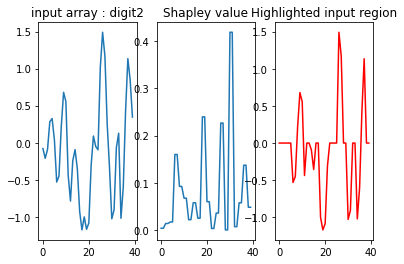

(-0.0, 1, 0.88955945, 0.9911539)
drop_rate 0.0
increase_rate 1.0


In [ ]:
indx = 0
drop_rate = 0
increase_rate = 0
a = 1
for idx in range(a):
    predict_y=model.predict(x_test[indx+idx:indx+idx+1])
    class_indx = np.argmax(predict_y[0])
    shapley=shap_user_defined(x_test[indx+idx:idx+indx+1],model,[2,1],1000)
    # plot test data
    plt.subplot(1,3,1)
    str1 = "input array : digit" + str(np.argmax(predict_y[0]))
    plt.plot(x_test[idx+indx])
    plt.title(str1)

    total_drop = calculate_drop_increase(x_test[indx+idx:indx+idx+1], model, shapley, class_indx, 0.3)
    drop_rate += total_drop[0]
    increase_rate += total_drop[1]

    plt.subplot(1,3,2)
    plt.plot(abs(shapley))
    plt.title('Shapley value')

    x2 = x_test[idx+indx].copy()
    plt.subplot(1,3,3)
    x2[abs(shapley)<0.05]=0
    plt.plot(x2,color = 'red')
    plt.title('Highlighted input region')
    plt.show()

print(total_drop)
print("drop_rate",drop_rate/a)
print("increase_rate",increase_rate/a)

calculate total drop/increase rate

In [ ]:
drop_rate = 0
increase_rate = 0
total_times = 0



In [ ]:
for idx in range(1000):
    predict_y=model.predict(x_test[total_times:total_times+1])
    class_indx = np.argmax(predict_y[0])
    shapley=shap_user_defined(x_test[total_times:total_times+1],model,[2,1],200)
    total_drop = calculate_drop_increase(x_test[total_times:total_times+1], model, shapley, class_indx, 0.3)
    drop_rate += total_drop[0]
    increase_rate += total_drop[1]
    total_times = total_times + 1
    print(total_times,":",total_drop[0])
    print(total_times,":",total_drop[1])
print(drop_rate)
print(increase_rate)
print(total_times)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

1 : -0.0
1 : 1
2 : -0.0
2 : 1
3 : -0.0
3 : 1
4 : -0.0
4 : 1
5 : -0.0
5 : 1
6 : -0.0
6 : 1
7 : -0.0
7 : 1
8 : -0.0
8 : 1
9 : -0.0
9 : 1
10 : -0.0
10 : 1
11 : -0.0
11 : 1
12 : 0.0014757673012360752
12 : 0
13 : 0.0019177048149632118
13 : 0
14 : 8.893018301140249e-05
14 : 0
15 : -0.0
15 : 1
16 : -0.0
16 : 1
17 : -0.0
17 : 1
18 : -0.0
18 : 1
19 : 0.0
19 : 0
20 : -0.0
20 : 1
21 : -0.0
21 : 1
22 : -0.0
22 : 1
23 : -0.0
23 : 1
24 : 0.00018817370298429068
24 : 0
25 : 0.00012874917907496815
25 : 0
26 : -0.0
26 : 1
27 : -0.0
27 : 1
28 : -0.0
28 : 1
29 : -0.0
29 : 1
30 : -0.0
30 : 1
31 : -0.0
31 : 1
32 : -0.0
32 : 1
33 : -0.0
33 : 1
34 : -0.0
34 : 1
35 : -0.0
35 : 1
36 : -0.0
36 : 1
37 : -0.0
37 : 1
38 : -0.0
38 : 1
39 : 0.0012282745619728534
39 : 0
40 : 0.0
40 : 0
41 : -0.0
41 : 1
42 : 0.00848187292863274
42 : 0
43 : 0.004399876531951054
43 : 0
44 : -0.0
44 : 1
45 : -0.0
45 : 1
46 : -0.0
46 : 1
47 : 0.0
47 : 0
48 : -0.0
48 : 1
49 : 0.018221861284930266
49 : 0
50 : -0.0
50 : 1
51 : 0.0
51 : 0
52 :

In [ ]:
for idx in range(128):
    predict_y=model.predict(x_test[total_times:total_times+1])
    class_indx = np.argmax(predict_y[0])
    shapley=shap_user_defined(x_test[total_times:total_times+1],model,[2,1],200)
    total_drop = calculate_drop_increase(x_test[total_times:total_times+1], model, shapley, class_indx, 0.3)
    drop_rate += total_drop[0]
    increase_rate += total_drop[1]
    total_times = total_times + 1
    print(total_times,":",total_drop[0])
    print(total_times,":",total_drop[1])
print(drop_rate)
print(increase_rate)
print(total_times)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

872 : -0.0
872 : 1
873 : -0.0
873 : 1
874 : -0.0
874 : 1
875 : -0.0
875 : 1
876 : 0.009456457162752833
876 : 0
877 : 0.0004121430847178147
877 : 0
878 : -0.0
878 : 1
879 : -0.0
879 : 1
880 : -0.0
880 : 1
881 : -0.0
881 : 1
882 : -0.0
882 : 1
883 : 0.6364425644622115
883 : 0
884 : 0.0
884 : 0
885 : -0.0
885 : 1
886 : 0.6617090830447192
886 : 0
887 : -0.0
887 : 1
888 : -0.0
888 : 1
889 : 0.6758783204032215
889 : 0
890 : -0.0
890 : 1
891 : 0.02107304684290335
891 : 0
892 : -0.0
892 : 1
893 : 4.768374424203887e-07
893 : 0
894 : 1.6819307849696225e-05
894 : 0
895 : -0.0
895 : 1
896 : -0.0
896 : 1
897 : 0.0032171476258241213
897 : 0
898 : -0.0
898 : 1
899 : 6.175225234783733e-05
899 : 0
900 : -0.0
900 : 1
901 : -0.0
901 : 1
902 : -0.0
902 : 1
903 : 0.0001031161706778857
903 : 0
904 : -0.0
904 : 1
905 : 0.005221883205612994
905 : 0
906 : -0.0
906 : 1
907 : 0.6602138012055675
907 : 0
908 : -0.0
908 : 1
909 : -0.0
909 : 1
910 : 0.03942464991464008
910 : 0
911 : 0.9996783683168647
911 : 0
912 : 